In [1]:
from abc import ABC, abstractmethod
from random import choice as random_choice
from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
from numpy import typing as npt
from typing_extensions import override

from rich.console import Console
from rich.progress import Progress, TaskID
from rich.table import Table

In [2]:
console = Console()

## Code provided in question

In [3]:
"""Environment for Modified Travelling Salesman Problem."""


class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits ar to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(
            self.num_targets
        )
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(
            self.locations
        )

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = (
            np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        )
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(
                    self.num_targets, dtype=np.float32
                ),  # Check if targets were visited or not
                np.zeros(
                    self.num_targets, dtype=np.float32
                ),  # Array of all current profits values
                np.zeros(
                    self.num_targets, dtype=np.float32
                ),  # Distance to each target from current location
                np.zeros(
                    2 * self.num_targets, dtype=np.float32
                ),  # Cooridinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(
                    self.num_targets, dtype=np.float32
                ),  # Check if targets were visited or not
                100
                * np.ones(
                    self.num_targets, dtype=np.float32
                ),  # Array of all current profits values
                2
                * self.max_area
                * np.ones(
                    self.num_targets, dtype=np.float32
                ),  # Distance to each target from current location
                self.max_area
                * np.ones(
                    2 * self.num_targets, dtype=np.float32
                ),  # Coordinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(
            self.num_targets, dtype=np.float32
        )
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(
        self, action: int
    ) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = self.steps == self.max_steps
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(
            low=0, high=self.max_area, size=(num_points, 2)
        ).astype(np.float32)

    def _calculate_distances(
        self, locations: npt.NDArray[np.float32]
    ) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = (
            self.current_profits[next_loc]
            if not self.visited_targets[next_loc]
            else -1e4
        )
        return float(reward)

## Solution

### Using Q-Learning

In [4]:
Action = int
TSP_Obs = npt.NDArray[np.float32]
State = Tuple[int, ...]
EpisodeStep = Tuple[TSP_Obs, Action, float]
Episode = List[EpisodeStep]

def tsp_obs_to_state_repr(tsp_obs: TSP_Obs) -> State:
    """
    Converts an observation from the ModTSP environment to a
    hashable (tuple) representation which can be used in keys for a Dict.

    Args:
        tsp_obs (np.ndarray): The observation obtained from the TSP environment.

    Returns:
         Tuple[int, ...]: The tuple representation of the state observation.
    """
    return tuple(tsp_obs[:11].flatten())

In [5]:
class DecayContext(ABC):
    _value: float
    _history: List[float]

    def __init__(self, v0: float) -> None:
        self._value = v0
        self._history = []

    @property
    def value(self) -> float:
        return self._value
    
    @property
    def history(self) -> List[float]:
        return self._history

    @abstractmethod
    def update(self) -> None:
        pass


class ExpDecayContext(DecayContext):
    _eta: float

    def __init__(self, v0: float, eta: float) -> None:
        super().__init__(v0=v0)
        self._eta = eta

    @override
    def update(self) -> None:
        self._value *= self._eta

In [6]:
class QTable(Dict[Tuple[TSP_Obs, Action], float]):
    """
    The Q-Table to be used for Q-Learning.
    """

    _table: Dict[State, Dict[Action, float]]
    _actions: List[Action]

    def __init__(self, actions: List[Action]) -> None:
        super().__init__()
        self._table = dict()
        self._actions = actions

    def __setitem__(
        self, key: Tuple[TSP_Obs, Action], value: float
    ) -> None:
        tsp_obs, action = key
        state = self._ensure_key(tsp_obs=tsp_obs)
        self._table[state][action] = value

    def __getitem__(self, key: Tuple[TSP_Obs, Action]) -> float:
        tsp_obs, action = key
        self._ensure_key(tsp_obs=tsp_obs)
        return self._table[tsp_obs_to_state_repr(tsp_obs=tsp_obs)][action]
    
    def _ensure_key(self, tsp_obs: TSP_Obs) -> State:
        state = tsp_obs_to_state_repr(tsp_obs=tsp_obs)
        if state not in self._table:
            self._table[state] = {a: np.random.randn() for a in self._actions}
        return state
    
    def get_action_values(self, tsp_obs: TSP_Obs) -> Dict[Action, float]:
        self._ensure_key(tsp_obs=tsp_obs)
        return self._table[tsp_obs_to_state_repr(tsp_obs=tsp_obs)]

### Create the Solver Algorithm

We use **Q-Learning** here.

In [7]:
class Solver(ABC):
    _env: ModTSP
    _alpha: float
    _gamma: float
    _n_episodes: int
    _episode_max_len: int
    _actions: List[Action]
    _q_table: QTable

    def __init__(
        self,
        env: ModTSP,
        alpha: float,
        epsilon: float,
        gamma: float,
        episode_max_len: int,
        actions: List[Action],
    ) -> None:
        self._env = env
        self._alpha = alpha
        self._epsilon = epsilon
        self._gamma = gamma
        self._episode_max_len = episode_max_len
        self._actions = actions
        self._q_table = QTable(actions=actions)

    def _epsilon_greedy_action(self, tsp_obs: TSP_Obs) -> Action:
        action_values = self._q_table.get_action_values(tsp_obs=tsp_obs)
        if np.random.randn() < self._epsilon:
            # Choose random action
            return random_choice(list(action_values.keys()))
        else:
            # Choose maximal action
            best_action, max_value = -1, -np.inf
            for a, q in self._q_table.get_action_values(tsp_obs=tsp_obs).items():
                if q > max_value:
                    max_value = q
                    best_action = a
            return best_action

    def _generate_episode(self) -> Episode:
        episode: Episode = []
        curr_obs, _ = self._env.reset()
        for _ in range(self._episode_max_len):
            if len(episode) == 0:
                action = self._env.action_space.sample()
            else:
                action = self._epsilon_greedy_action(tsp_obs=curr_obs)
            next_obs, reward, term, trunc, _ = self._env.step(action=action)
            episode.append((curr_obs, action, reward))
            curr_obs = next_obs
            if term or trunc:
                break
        return episode

    @abstractmethod
    def _calculate_td_error(self, episode: Episode, step_inx: int) -> float:
        pass

    def _update_params(self) -> None:
        pass

    def solve(self, n_episodes: int, progress: Progress | None = None, task_id: TaskID | None = None) -> Tuple[QTable, List[float]]:
        episode_returns: List[float] = []
        for _ in range(n_episodes):
            episode = self._generate_episode()
            episode_return = 0
            q_new: List[Tuple[Tuple[TSP_Obs, Action], float]] = []
            for i, (state, action, reward) in enumerate(episode[::-1]):
                q_old = self._q_table[state, action]
                td_error = self._calculate_td_error(episode=episode, step_inx=-(i + 1))
                q_new.append(
                    (
                        (state, action),
                        (1 - self._alpha) * q_old + self._alpha * td_error,
                    )
                )
                episode_return = self._gamma * episode_return + reward
            for (state, action), q_value in q_new:
                self._q_table[state, action] = q_value
            episode_returns.append(episode_return)
            self._update_params()

            # Update the progress UI if required
            if progress and task_id:
                progress.update(task_id=task_id, advance=1, refresh=True)

        return self._q_table, episode_returns


class DecayAlphaEpsilonSolver(Solver, ABC):
    _decay_alpha: ExpDecayContext
    _decay_epsilon: ExpDecayContext

    def __init__(
        self,
        env: ModTSP,
        alpha: float,
        epsilon: float,
        gamma: float,
        episode_max_len: int,
        actions: List[int],
        eta_alpha: float = 0.99,
        eta_epsilon: float = 0.99,
    ) -> None:
        super().__init__(env, alpha, epsilon, gamma, episode_max_len, actions)
        self._decay_alpha = ExpDecayContext(v0=alpha, eta=eta_alpha)
        self._decay_epsilon = ExpDecayContext(v0=epsilon, eta=eta_epsilon)

    @override
    def _update_params(self) -> None:
        self._decay_alpha.update()
        self._decay_epsilon.update()
        self._alpha = self._decay_alpha.value
        self._epsilon = self._decay_epsilon.value

## Q-Learning Solver

- Here is the implementation of the Q-Learning algorithm (using all helpers defined above).
- Only the `_calculate_td_error` method is defined (overriden) as the only difference between temporal-difference algorithms is that step.

In [8]:
class QLearningSolver(DecayAlphaEpsilonSolver):
    def __init__(
        self,
        env: ModTSP,
        alpha: float,
        epsilon: float,
        gamma: float,
        episode_max_len: int,
        actions: List[int],
        eta_alpha: float = 0.99,
        eta_epsilon: float = 0.99,
    ) -> None:
        super().__init__(
            env=env,
            alpha=alpha,
            epsilon=epsilon,
            gamma=gamma,
            episode_max_len=episode_max_len,
            actions=actions,
            eta_alpha=eta_alpha,
            eta_epsilon=eta_epsilon,
        )

    @override
    def _calculate_td_error(self, episode: Episode, step_inx: int) -> float:
        state, action, reward = episode[step_inx]
        q_old = self._q_table[state, action]
        td_target_estimate = reward + self._gamma * np.max(
            list(self._q_table.get_action_values(tsp_obs=state).values())
        )
        td_error = td_target_estimate - q_old
        return td_error

### SARSA Algorithm

- Here is the implementation of the **SARSA** algorithm.

In [9]:
class SARSA_Solver(DecayAlphaEpsilonSolver):
    def __init__(
        self,
        env: ModTSP,
        alpha: float,
        epsilon: float,
        gamma: float,
        episode_max_len: int,
        actions: List[int],
        eta_alpha: float = 0.99,
        eta_epsilon: float = 0.99,
    ) -> None:
        super().__init__(
            env=env,
            alpha=alpha,
            epsilon=epsilon,
            gamma=gamma,
            episode_max_len=episode_max_len,
            actions=actions,
            eta_alpha=eta_alpha,
            eta_epsilon=eta_epsilon,
        )

    @override
    def _calculate_td_error(
        self, episode: List[Tuple[TSP_Obs, int, float]], step_inx: int
    ) -> float:
        state, action, reward = episode[step_inx]
        next_state, next_action, _ = episode[step_inx + 1]
        q_old = self._q_table[state, action]
        td_error = (
            reward + self._gamma * self._q_table[next_state, next_action] - q_old
            if step_inx < -1
            else q_old
        )
        return td_error

### Run Q-Learning Algorithm

Output()

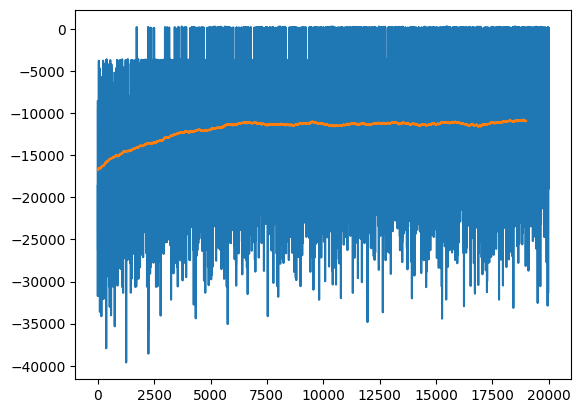

In [10]:
num_targets = 10
n_episodes = 20_000

env = ModTSP(num_targets=num_targets, seed=69)
tsp_obs, _ = env.reset()
solver = QLearningSolver(
    env=env,
    alpha=0.13,
    epsilon=0.2,
    gamma=0.9,
    episode_max_len=num_targets,
    actions=list(range(num_targets)),
    eta_epsilon=0.97,
    eta_alpha=0.999
)
with Progress(console=console, auto_refresh=False) as progress:
    solve_task = progress.add_task("Solve using Q-Learning", total=n_episodes)
    qt_qlearning, episode_returns = solver.solve(n_episodes=n_episodes, progress=progress, task_id=solve_task)

window_size = round(n_episodes * 0.05)
plt.plot(episode_returns)
plt.plot(
    np.convolve(episode_returns, np.ones(window_size) / window_size)[
        window_size:-window_size
    ],
)

### Run SARSA Algorithm

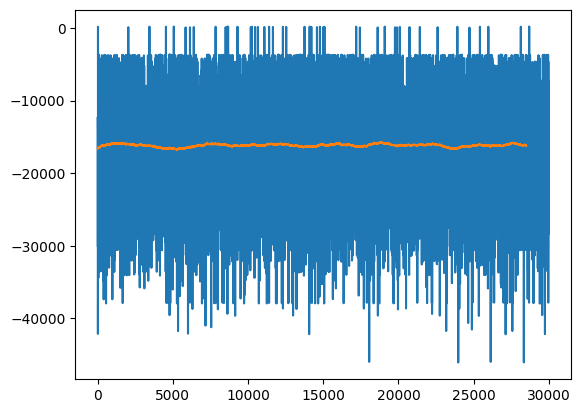

In [11]:
num_targets = 10
n_episodes = 30000

env = ModTSP(num_targets=num_targets, seed=69)
tsp_obs, _ = env.reset()
solver = SARSA_Solver(
    env=env,
    alpha=0.03,
    epsilon=0.02,
    gamma=0.9,
    episode_max_len=num_targets,
    actions=list(range(num_targets)),
)
qt_sarsa, episode_returns = solver.solve(n_episodes=n_episodes)

window_size = round(n_episodes * 0.05)
plt.plot(episode_returns)
plt.plot(
    np.convolve(episode_returns, np.ones(window_size) / window_size)[
        window_size:-window_size
    ],
)

In [12]:
class Policy(Dict[TSP_Obs, Action]):
    _q_table: QTable

    def __init__(self, q_table: QTable) -> None:
        self._q_table = q_table

    def __getitem__(self, key: TSP_Obs) -> int:
        best_action = self._q_table._actions[
            np.argmax(list(self._q_table.get_action_values(tsp_obs=key).values()))
        ]
        return best_action

### Main code given in question

- Changed to show table instead of simple prints
- Shows unique states for each path
- Also shows actual path followed in that episode

In [13]:
def evaluate_q_table(q_table: QTable) -> None:
    """Main function."""
    # num_targets = 10

    env = ModTSP(num_targets=num_targets, seed=69)
    policy = Policy(q_table=q_table)   # Evaluate Q-Learning
    obs_, _ = env.reset()
    ep_rets = []

    table = Table()
    table.add_column("Ep #", justify="center")
    table.add_column("Reward", justify="center", style="bold cyan")
    table.add_column("Unique", style="magenta")
    table.add_column("Path", style="dim")

    for ep in range(100):
        ret = 0
        obs_, _ = env.reset()
        episode = []
        for _ in range(1000):
            # action = (
            #     env.action_space.sample()
            # )  # You need to replace this with your algorithm that predicts the action.
            if not episode:
                best_action = env.action_space.sample()
            else:
                best_action = policy[obs_]

            obs_, reward, terminated, truncated, _ = env.step(action=best_action)
            done = terminated or truncated
            ret += reward
            episode.append(int(obs_[0]))

            if done:
                break
        # print(f"Episode {ep} : {ret}")
        ep_rets.append(ret)
        # print(f"State sequence: {episode}")
        # print(f"n states in sequence: {}")
        table.add_row(str(ep + 1), f"{ret :.3f}", str(np.unique(episode).shape[0]), str(episode))

    console.print(f"[dim]Mean Return per episode[/] = [bold red]{np.mean(ep_rets) :.3f}[/]")
    console.print(table)

### Evaluate Q-Learning

In [14]:
evaluate_q_table(q_table=qt_qlearning)

Mean Return per episode = 166.615

┏━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Ep # ┃ Reward  ┃ Unique ┃ Path                           ┃
┡━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  1   │ 159.744 │ 10     │ [9, 4, 3, 8, 2, 5, 0, 7, 6, 1] │
│  2   │ 32.975  │ 10     │ [3, 5, 2, 0, 4, 8, 7, 6, 9, 1] │
│  3   │ 173.224 │ 10     │ [7, 2, 3, 0, 5, 4, 8, 9, 6, 1] │
│  4   │ 159.744 │ 10     │ [9, 4, 3, 8, 2, 5, 0, 7, 6, 1] │
│  5   │ 132.584 │ 10     │ [6, 5, 4, 8, 3, 2, 0, 7, 9, 1] │
│  6   │ 44.562  │ 10     │ [8, 5, 3, 2, 0, 4, 7, 6, 9, 1] │
│  7   │ 329.620 │ 10     │ [0, 5, 4, 2, 8, 7, 3, 6, 9, 1] │
│  8   │ 329.620 │ 10     │ [0, 5, 4, 2, 8, 7, 3, 6, 9, 1] │
│  9   │ 199.627 │ 10     │ [1, 5, 3, 2, 8, 4, 0, 7, 9, 6] │
│  10  │ 176.454 │ 10     │ [2, 4, 5, 0, 3, 8, 7, 6, 9, 1] │
│  11  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  12  │ 329.620 │ 10     │ [0, 5, 4, 2, 8, 7, 3, 6, 9, 1] │
│  13  │ 173.224 │ 10     │ [7, 2, 3, 0, 5, 4, 8, 9, 6, 1] │
│  14  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  15  │ 329.620 │ 10     │ [0, 5, 4, 2, 8, 7, 3, 6, 9, 1] │
│  16  │ 159.744 │ 10     │ [9, 4, 3, 8, 2, 5, 0, 7, 6, 1] │
│  17  │ 159.744 │ 10     │ [9, 4, 3, 8, 2, 5, 0, 7, 6, 1] │
│  18  │ 175.978 │ 10     │ [4, 5, 2, 3, 7, 0, 8, 9, 6, 1] │
│  19  │ 132.584 │ 10     │ [6, 5, 4, 8, 3, 2, 0, 7, 9, 1] │
│  20  │ 32.975  │ 10     │ [3, 5, 2, 0, 4, 8, 7, 6, 9, 1] │
│  21  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  22  │ 32.975  │ 10     │ [3, 5, 2, 0, 4, 8, 7, 6, 9, 1] │
│  23  │ 32.975  │ 10     │ [3, 5, 2, 0, 4, 8, 7, 6, 9, 1] │
│  24  │ 175.978 │ 10     │ [4, 5, 2, 3, 7, 0, 8, 9, 6, 1] │
│  25  │ 176.454 │ 10     │ [2, 4, 5, 0, 3, 8, 7, 6, 9, 1] │
│  26  │ 175.978 │ 10     │ [4, 5, 2, 3, 7, 0, 8, 9, 6, 1] │
│  27  │ 44.562  │ 10     │ [8, 5, 3, 2, 0, 4, 7, 6, 9, 1] │
│  28  │ 175.978 │ 10     │ [4, 5, 2, 3, 7, 0, 8, 9, 6, 1] │
│  29  │ 159.744 │ 10     │ [9, 4, 3, 8, 2, 5, 0, 7, 6, 1] │
│  30  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  31  │ 176.454 │ 10     │ [2, 4, 5, 0, 3, 8, 7, 6, 9, 1] │
│  32  │ 132.584 │ 10     │ [6, 5, 4, 8, 3, 2, 0, 7, 9, 1] │
│  33  │ 32.975  │ 10     │ [3, 5, 2, 0, 4, 8, 7, 6, 9, 1] │
│  34  │ 44.562  │ 10     │ [8, 5, 3, 2, 0, 4, 7, 6, 9, 1] │
│  35  │ 44.562  │ 10     │ [8, 5, 3, 2, 0, 4, 7, 6, 9, 1] │
│  36  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  37  │ 132.584 │ 10     │ [6, 5, 4, 8, 3, 2, 0, 7, 9, 1] │
│  38  │ 199.627 │ 10     │ [1, 5, 3, 2, 8, 4, 0, 7, 9, 6] │
│  39  │ 32.975  │ 10     │ [3, 5, 2, 0, 4, 8, 7, 6, 9, 1] │
│  40  │ 132.584 │ 10     │ [6, 5, 4, 8, 3, 2, 0, 7, 9, 1] │
│  41  │ 175.978 │ 10     │ [4, 5, 2, 3, 7, 0, 8, 9, 6, 1] │
│  42  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  43  │ 329.620 │ 10     │ [0, 5, 4, 2, 8, 7, 3, 6, 9, 1] │
│  44  │ 175.978 │ 10     │ [4, 5, 2, 3, 7, 0, 8, 9, 6, 1] │
│  45  │ 132.584 │ 10     │ [6, 5, 4, 8, 3, 2, 0, 7, 9, 1] │
│  46  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  47  │ 176.454 │ 10     │ [2, 4, 5, 0, 3, 8, 7, 6, 9, 1] │
│  48  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  49  │ 159.744 │ 10     │ [9, 4, 3, 8, 2, 5, 0, 7, 6, 1] │
│  50  │ 176.454 │ 10     │ [2, 4, 5, 0, 3, 8, 7, 6, 9, 1] │
│  51  │ 159.744 │ 10     │ [9, 4, 3, 8, 2, 5, 0, 7, 6, 1] │
│  52  │ 173.224 │ 10     │ [7, 2, 3, 0, 5, 4, 8, 9, 6, 1] │
│  53  │ 199.627 │ 10     │ [1, 5, 3, 2, 8, 4, 0, 7, 9, 6] │
│  54  │ 176.454 │ 10     │ [2, 4, 5, 0, 3, 8, 7, 6, 9, 1] │
│  55  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  56  │ 176.454 │ 10     │ [2, 4, 5, 0, 3, 8, 7, 6, 9, 1] │
│  57  │ 44.562  │ 10     │ [8, 5, 3, 2, 0, 4, 7, 6, 9, 1] │
│  58  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  59  │ 199.627 │ 10     │ [1, 5, 3, 2, 8, 4, 0, 7, 9, 6] │
│  60  │ 329.620 │ 10     │ [0, 5, 4, 2, 8, 7, 3, 6, 9, 1] │
│  61  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  62  │ 181.746 │ 10     │ [5, 4, 2, 3, 7, 0, 8, 9, 6, 1] │
│  63  │ 176.454 │ 10     │ [2, 4, 

### Evaluate SARSA

In [15]:
evaluate_q_table(q_table=qt_sarsa)

Mean Return per episode = -20022.137

┏━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Ep # ┃   Reward   ┃ Unique ┃ Path                           ┃
┡━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  1   │ -19781.651 │ 8      │ [2, 7, 3, 6, 4, 1, 5, 0, 1, 0] │
│  2   │ -39793.543 │ 6      │ [5, 9, 1, 2, 6, 3, 9, 3, 9, 3] │
│  3   │ -19876.289 │ 8      │ [3, 4, 5, 2, 9, 7, 5, 8, 0, 2] │
│  4   │ -39793.543 │ 6      │ [5, 9, 1, 2, 6, 3, 9, 3, 9, 3] │
│  5   │ -19871.651 │ 8      │ [2, 7, 3, 6, 4, 1, 5, 0, 1, 0] │
│  6   │ -9782.389  │ 9      │ [4, 9, 7, 5, 3, 8, 6, 0, 1, 8] │
│  7   │ -39883.543 │ 6      │ [5, 9, 1, 2, 6, 3, 9, 3, 9, 3] │
│  8   │ -9782.389  │ 9      │ [4, 9, 7, 5, 3, 8, 6, 0, 1, 8] │
│  9   │ -39776.775 │ 6      │ [9, 7, 2, 4, 5, 0, 0, 0, 0, 0] │
│  10  │ -19791.651 │ 8      │ [2, 7, 3, 6, 4, 1, 5, 0, 1, 0] │
│  11  │ -9835.215  │ 9      │ [8, 3, 0, 7, 2, 4, 9, 0, 5, 1] │
│  12  │ -19791.651 │ 8      │ [2, 7, 3, 6, 4, 1, 5, 0, 1, 0] │
│  13  │  189.109   │ 10     │ [1, 9, 3, 2, 5, 6, 7, 0, 4, 8] │
│  14  │ -19876.289 │ 8      │ [3, 4, 5, 2, 9, 7, 5, 8, 0, 2] │
│  15  │ -9802.389  │ 9      │ [4, 9, 7, 5, 3, 8, 6, 0, 1, 8] │
│  16  │  189.109   │ 10     │ [1, 9, 3, 2, 5, 6, 7, 0, 4, 8] │
│  17  │ -29786.435 │ 7      │ [0, 3, 6, 7, 9, 8, 4, 3, 8, 3] │
│  18  │  189.109   │ 10     │ [1, 9, 3, 2, 5, 6, 7, 0, 4, 8] │
│  19  │ -9856.454  │ 9      │ [6, 7, 9, 8, 4, 3, 5, 0, 1, 8] │
│  20  │  189.109   │ 10     │ [1, 9, 3, 2, 5, 6, 7, 0, 4, 8] │
│  21  │ -39746.775 │ 6      │ [9, 7, 2, 4, 5, 0, 0, 0, 0, 0] │
│  22  │ -9856.454  │ 9      │ [6, 7, 9, 8, 4, 3, 5, 0, 1, 8] │
│  23  │ -39746.775 │ 6      │ [9, 7, 2, 4, 5, 0, 0, 0, 0, 0] │
│  24  │  189.109   │ 10     │ [1, 9, 3, 2, 5, 6, 7, 0, 4, 8] │
│  25  │ -39803.543 │ 6      │ [5, 9, 1, 2, 6, 3, 9, 3, 9, 3] │
│  26  │ -29786.435 │ 7      │ [0, 3, 6, 7, 9, 8, 4, 3, 8, 3] │
│  27  │ -9802.389  │ 9      │ [4, 9, 7, 5, 3, 8, 6, 0, 1, 8] │
│  28  │ -19876.289 │ 8      │ [3, 4, 5, 2, 9, 7, 5, 8, 0, 2] │
│  29  │ -19923.495 │ 8      │ [7, 1, 2, 5, 3, 4, 8, 9, 1, 9] │
│  30  │ -39803.543 │ 6      │ [5, 9, 1, 2, 6, 3, 9, 3, 9, 3] │
│  31  │ -19876.289 │ 8      │ [3, 4, 5, 2, 9, 7, 5, 8, 0, 2] │
│  32  │ -19791.651 │ 8      │ [2, 7, 3, 6, 4, 1, 5, 0, 1, 0] │
│  33  │ -39746.775 │ 6      │ [9, 7, 2, 4, 5, 0, 0, 0, 0, 0] │
│  34  │ -19791.651 │ 8      │ [2, 7, 3, 6, 4, 1, 5, 0, 1, 0] │
│  35  │  189.109   │ 10     │ [1, 9, 3, 2, 5, 6, 7, 0, 4, 8] │
│  36  │ -9802.389  │ 9      │ [4, 9, 7, 5, 3, 8, 6, 0, 1, 8] │
│  37  │ -9835.215  │ 9      │ [8, 3, 0, 7, 2, 4, 9, 0, 5, 1] │
│  38  │ -39746.775 │ 6      │ [9, 7, 2, 4, 5, 0, 0, 0, 0, 0] │
│  39  │ -39746.775 │ 6      │ [9, 7, 2, 4, 5, 0, 0, 0, 0, 0] │
│  40  │ -19923.495 │ 8      │ [7, 1, 2, 5, 3, 4, 8, 9, 1, 9] │
│  41  │ -19923.495 │ 8      │ [7, 1, 2, 5, 3, 4, 8, 9, 1, 9] │
│  42  │ -29786.435 │ 7      │ [0, 3, 6, 7, 9, 8, 4, 3, 8, 3] │
│  43  │ -9856.454  │ 9      │ [6, 7, 9, 8, 4, 3, 5, 0, 1, 8] │
│  44  │ -9835.215  │ 9      │ [8, 3, 0, 7, 2, 4, 9, 0, 5, 1] │
│  45  │ -19876.289 │ 8      │ [3, 4, 5, 2, 9, 7, 5, 8, 0, 2] │
│  46  │ -39746.775 │ 6      │ [9, 7, 2, 4, 5, 0, 0, 0, 0, 0] │
│  47  │  189.109   │ 10     │ [1, 9, 3, 2, 5, 6, 7, 0, 4, 8] │
│  48  │ -9856.454  │ 9      │ [6, 7, 9, 8, 4, 3, 5, 0, 1, 8] │
│  49  │ -39803.543 │ 6      │ [5, 9, 1, 2, 6, 3, 9, 3, 9, 3] │
│  50  │ -19876.289 │ 8      │ [3, 4, 5, 2, 9, 7, 5, 8, 0, 2] │
│  51  │ -19876.289 │ 8      │ [3, 4, 5, 2, 9, 7, 5, 8, 0, 2] │
│  52  │ -9802.389  │ 9      │ [4, 9, 7, 5, 3, 8, 6, 0, 1, 8] │
│  53  │ -19923.495 │ 8      │ [7, 1, 2, 5, 3, 4, 8, 9, 1, 9] │
│  54  │ -19876.289 │ 8      │ [3, 4, 5, 2, 9, 7, 5, 8, 0, 2] │
│  55  │ -19791.651 │ 8      │ [2, 7, 3, 6, 4, 1, 5, 0, 1, 0] │
│  56  │ -39746.775 │ 6      │ [9, 7, 2, 4, 5, 0, 0, 0, 0, 0] │
│  57  │ -19876.289 │ 8      │ [3, 4, 5, 2, 9, 7, 5, 8, 0, 2] │
│  58  │  189.109   │ 10     │ [1, 9, 3, 2, 5, 6, 7, 0, 4, 8] │
│  59  │ -29786.435 │ 7      │ [0, 3, 6, 7, 9, 8, 4, 3, 8, 3] │
│  60  │ -29786.435 │ 7      │ [

### Plot Policy

- Generate an episode, starting from a random point.
- Follow the policy to get the next points.
- Stop episode when terminated.
- Plot the sequence of points.

In [16]:
def scatter_and_draw_arrows(scatter_points, arrow_points):
    # Check if there are enough points to draw arrows
    if len(arrow_points) < 2:
        print("Need at least two points to draw arrows.")
        return

    fig, ax = plt.subplots(dpi=128)
    fig.set_size_inches(12, 9)

    # Define Nord color palette (selected colors)
    nord_colors = {
        "red": "#BF616A",
        "blue": "#5E81AC",
        "light_blue": "#88C0D0",
        "green": "#A3BE8C",
        "yellow": "#EBCB8B",
    }

    # Scatter the points with bigger size
    ax.scatter(
        scatter_points[:, 0],
        scatter_points[:, 1],
        color=nord_colors["red"],
        s=100,
        label="Scatter Points",
    )

    # Highlight the first and last points in the arrow_points array
    ax.scatter(
        arrow_points[0, 0],
        arrow_points[0, 1],
        color=nord_colors["yellow"],
        s=250,
        label="Start Point",
    )
    ax.scatter(
        arrow_points[-1, 0],
        arrow_points[-1, 1],
        color=nord_colors["green"],
        s=250,
        label="End Point",
    )

    # Loop through the arrow points and draw arrows between consecutive points
    for i in range(len(arrow_points) - 1):
        start_point = arrow_points[i]
        end_point = arrow_points[i + 1]

        # Calculate the change in x and y (dx and dy)
        dx = end_point[0] - start_point[0]
        dy = end_point[1] - start_point[1]

        # Draw the arrow with bigger size
        ax.arrow(
            start_point[0],
            start_point[1],
            dx,
            dy,
            head_width=0.18,  # Bigger arrowhead
            head_length=0.3,
            linewidth=1.25,
            fc=nord_colors["light_blue"],
            ec=nord_colors["light_blue"],
            length_includes_head=True,
        )

    # Label the scatter points with large font size
    for i, point in enumerate(scatter_points):
        ax.text(
            point[0] + 0.1,
            point[1] + 0.1,
            f"{i+1} ({point[0] :.2f}, {point[1] :.2f})",
            fontsize=11,
            color=nord_colors["blue"],
            weight="bold",
        )

    # Set equal scaling on both axes
    ax.set_aspect("equal")

    # Add a legend
    ax.legend(loc="best", fontsize=14)

    ax.set_title("Sample Episode with Estimated Optimal Policy")


In [17]:
def plot_sample_episode(env: ModTSP, q_table: QTable):
    env.reset()
    points = []
    policy = Policy(q_table=q_table)
    state, _, term, trunc, _ = env.step(action=env.action_space.sample())
    state_locs = state[-2 * num_targets :].reshape(-1, 2)
    points.append(state_locs[int(state[0])])
    while not (term or trunc):
        state, _, term, trunc, _ = env.step(action=policy[state])
        points.append(state_locs[int(state[0])])
    points = np.array(points)
    scatter_and_draw_arrows(scatter_points=state_locs, arrow_points=points)

### Plotting Sample Episodes

#### Q-Learning

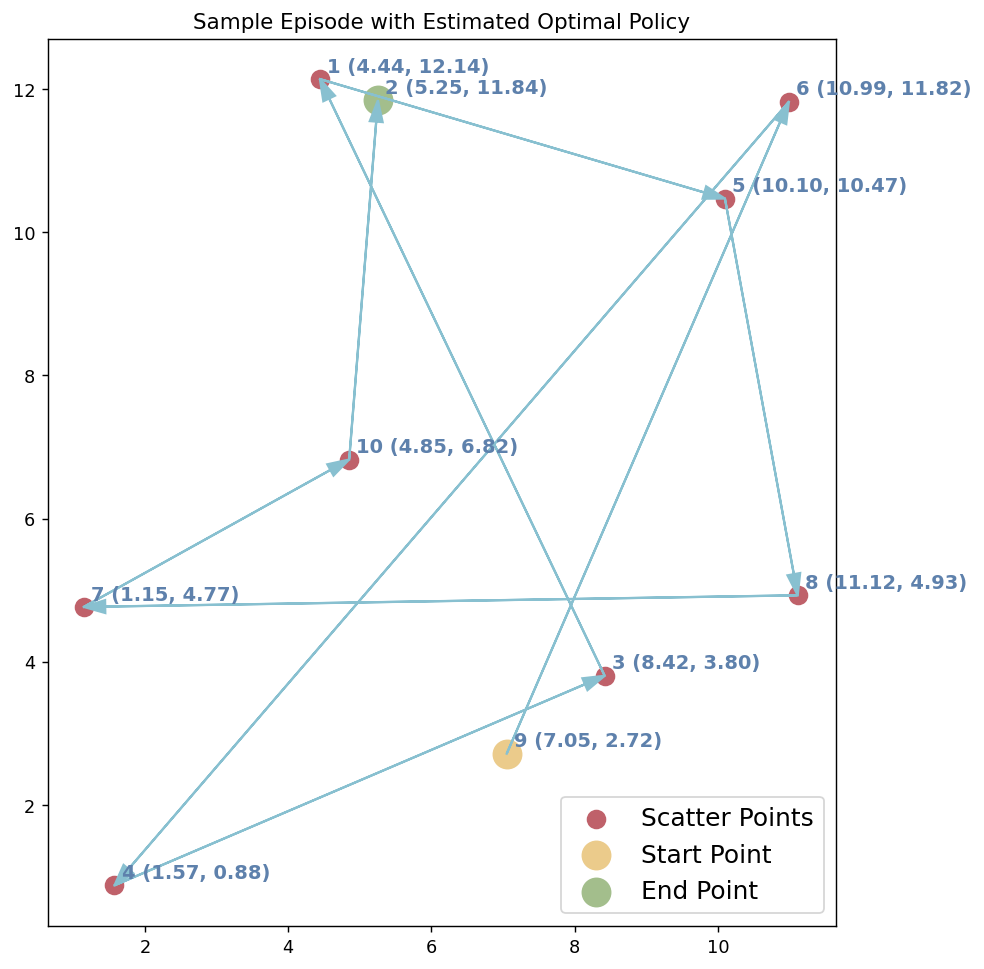

In [18]:
plot_sample_episode(env=env, q_table=qt_qlearning)

#### SARSA

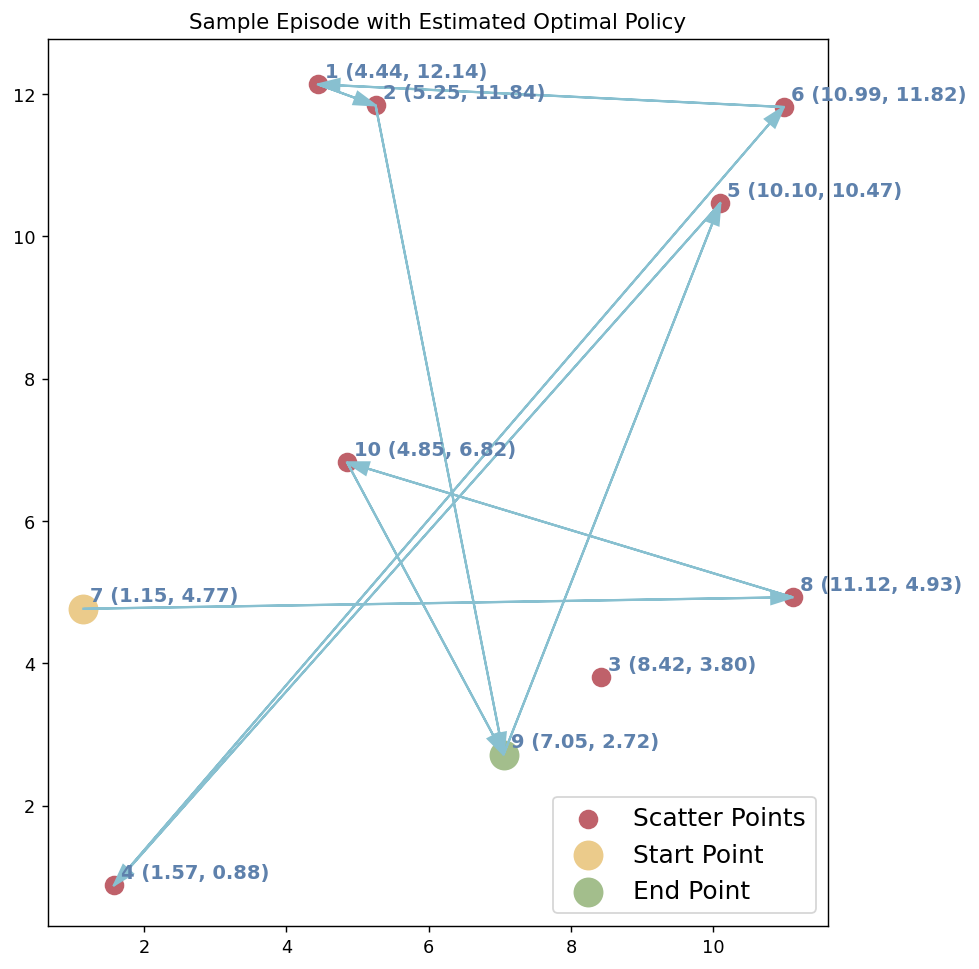

In [19]:
plot_sample_episode(env=env, q_table=qt_sarsa)